In [1]:
import sys 
import os

# Add the parent directory to the path if it's not already there
if os.path.abspath('..') not in sys.path:
    sys.path.append(os.path.abspath('..'))

In [2]:
%load_ext autoreload
%autoreload 2

In [8]:
from ddql_optimal_execution import DDQL, MarketEnvironnement, Trainer, TWAP
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

In [117]:
env = MarketEnvironnement(initial_inventory=500, multi_episodes=True, QV=True)

In [86]:
agent = DDQL(state_size=env.state_size, initial_budget=env.initial_inventory, horizon=env.horizon)

Using cpu device


In [87]:
trainer = Trainer(agent, env, capacity=10000)

In [88]:
trainer.fill_exp_replay(max_steps=1000)

/Users/g0bel1n/DDQL-optimal-execution/ddql_optimal_execution/trainer/_trainer.py:144: MaxStepsTooLowWarning: Max steps is too low. It is set to 10000.
  warnings.warn(MaxStepsTooLowWarning(max_steps))
Filling experience replay buffer: 10002it [00:35, 284.28it/s]                          


In [90]:
trainer.pretrain(max_steps=1000, batch_size=32)

Pretraining agent:   2%|▏         | 20/1000 [00:00<00:37, 26.09it/s]

Target network updated at step 15 with greediness 0.46


Pretraining agent:   4%|▎         | 35/1000 [00:01<00:37, 25.94it/s]

Target network updated at step 30 with greediness 0.21


Pretraining agent:   5%|▍         | 48/1000 [00:01<00:33, 28.22it/s]

Target network updated at step 45 with greediness 0.10


Pretraining agent:   7%|▋         | 66/1000 [00:02<00:31, 29.59it/s]

Target network updated at step 60 with greediness 0.05


Pretraining agent:   8%|▊         | 78/1000 [00:02<00:32, 28.35it/s]

Target network updated at step 75 with greediness 0.02


Pretraining agent:  10%|▉         | 96/1000 [00:03<00:30, 30.11it/s]

Target network updated at step 90 with greediness 0.01


Pretraining agent:  11%|█         | 111/1000 [00:04<00:29, 30.29it/s]

Target network updated at step 105 with greediness 0.01


Pretraining agent:  12%|█▏        | 124/1000 [00:04<00:31, 28.03it/s]

Target network updated at step 120 with greediness 0.01


Pretraining agent:  14%|█▍        | 140/1000 [00:05<00:29, 29.10it/s]

Target network updated at step 135 with greediness 0.01


Pretraining agent:  15%|█▌        | 153/1000 [00:05<00:30, 27.55it/s]

Target network updated at step 150 with greediness 0.01


Pretraining agent:  17%|█▋        | 171/1000 [00:06<00:27, 30.49it/s]

Target network updated at step 165 with greediness 0.01


Pretraining agent:  18%|█▊        | 183/1000 [00:06<00:27, 29.79it/s]

Target network updated at step 180 with greediness 0.01


Pretraining agent:  20%|█▉        | 198/1000 [00:07<00:26, 30.00it/s]

Target network updated at step 195 with greediness 0.01


Pretraining agent:  21%|██▏       | 213/1000 [00:07<00:25, 30.50it/s]

Target network updated at step 210 with greediness 0.01


Pretraining agent:  23%|██▎       | 229/1000 [00:08<00:24, 30.96it/s]

Target network updated at step 225 with greediness 0.01


Pretraining agent:  24%|██▍       | 245/1000 [00:08<00:24, 30.47it/s]

Target network updated at step 240 with greediness 0.01


Pretraining agent:  26%|██▌       | 261/1000 [00:09<00:25, 29.42it/s]

Target network updated at step 255 with greediness 0.01


Pretraining agent:  28%|██▊       | 276/1000 [00:09<00:23, 30.46it/s]

Target network updated at step 270 with greediness 0.01


Pretraining agent:  29%|██▉       | 288/1000 [00:10<00:23, 30.41it/s]

Target network updated at step 285 with greediness 0.01


Pretraining agent:  31%|███       | 306/1000 [00:10<00:23, 30.02it/s]

Target network updated at step 300 with greediness 0.01


Pretraining agent:  32%|███▏      | 320/1000 [00:11<00:22, 30.19it/s]

Target network updated at step 315 with greediness 0.01


Pretraining agent:  33%|███▎      | 332/1000 [00:11<00:23, 27.87it/s]

Target network updated at step 330 with greediness 0.01


Pretraining agent:  35%|███▌      | 350/1000 [00:12<00:22, 29.51it/s]

Target network updated at step 345 with greediness 0.01


Pretraining agent:  36%|███▋      | 364/1000 [00:12<00:21, 29.83it/s]

Target network updated at step 360 with greediness 0.01


Pretraining agent:  38%|███▊      | 379/1000 [00:13<00:20, 30.76it/s]

Target network updated at step 375 with greediness 0.01


Pretraining agent:  39%|███▉      | 394/1000 [00:13<00:19, 30.68it/s]

Target network updated at step 390 with greediness 0.01


Pretraining agent:  41%|████      | 410/1000 [00:14<00:19, 31.01it/s]

Target network updated at step 405 with greediness 0.01


Pretraining agent:  42%|████▏     | 421/1000 [00:14<00:20, 27.63it/s]

Target network updated at step 420 with greediness 0.01


Pretraining agent:  44%|████▍     | 439/1000 [00:15<00:20, 28.00it/s]

Target network updated at step 435 with greediness 0.01


Pretraining agent:  45%|████▌     | 454/1000 [00:15<00:19, 27.86it/s]

Target network updated at step 450 with greediness 0.01


Pretraining agent:  47%|████▋     | 469/1000 [00:16<00:18, 28.62it/s]

Target network updated at step 465 with greediness 0.01


Pretraining agent:  48%|████▊     | 485/1000 [00:16<00:17, 29.37it/s]

Target network updated at step 480 with greediness 0.01


Pretraining agent:  50%|████▉     | 498/1000 [00:17<00:16, 29.67it/s]

Target network updated at step 495 with greediness 0.01


Pretraining agent:  51%|█████▏    | 514/1000 [00:17<00:16, 30.33it/s]

Target network updated at step 510 with greediness 0.01


Pretraining agent:  53%|█████▎    | 529/1000 [00:18<00:16, 28.42it/s]

Target network updated at step 525 with greediness 0.01


Pretraining agent:  54%|█████▍    | 543/1000 [00:18<00:15, 30.13it/s]

Target network updated at step 540 with greediness 0.01


Pretraining agent:  56%|█████▌    | 561/1000 [00:19<00:14, 29.41it/s]

Target network updated at step 555 with greediness 0.01


Pretraining agent:  57%|█████▊    | 575/1000 [00:20<00:14, 29.97it/s]

Target network updated at step 570 with greediness 0.01


Pretraining agent:  59%|█████▉    | 589/1000 [00:20<00:13, 30.60it/s]

Target network updated at step 585 with greediness 0.01


Pretraining agent:  60%|██████    | 605/1000 [00:21<00:12, 30.61it/s]

Target network updated at step 600 with greediness 0.01


Pretraining agent:  62%|██████▏   | 621/1000 [00:21<00:12, 30.08it/s]

Target network updated at step 615 with greediness 0.01


Pretraining agent:  63%|██████▎   | 634/1000 [00:22<00:14, 25.82it/s]

Target network updated at step 630 with greediness 0.01


Pretraining agent:  65%|██████▍   | 648/1000 [00:22<00:12, 28.57it/s]

Target network updated at step 645 with greediness 0.01


Pretraining agent:  67%|██████▋   | 666/1000 [00:23<00:11, 29.69it/s]

Target network updated at step 660 with greediness 0.01


Pretraining agent:  68%|██████▊   | 679/1000 [00:23<00:11, 29.12it/s]

Target network updated at step 675 with greediness 0.01


Pretraining agent:  70%|██████▉   | 695/1000 [00:24<00:10, 29.90it/s]

Target network updated at step 690 with greediness 0.01


Pretraining agent:  71%|███████   | 710/1000 [00:24<00:09, 29.39it/s]

Target network updated at step 705 with greediness 0.01


Pretraining agent:  72%|███████▏  | 724/1000 [00:25<00:09, 30.04it/s]

Target network updated at step 720 with greediness 0.01


Pretraining agent:  74%|███████▍  | 738/1000 [00:25<00:09, 29.09it/s]

Target network updated at step 735 with greediness 0.01


Pretraining agent:  75%|███████▌  | 753/1000 [00:26<00:08, 29.88it/s]

Target network updated at step 750 with greediness 0.01


Pretraining agent:  77%|███████▋  | 768/1000 [00:26<00:07, 29.86it/s]

Target network updated at step 765 with greediness 0.01


Pretraining agent:  78%|███████▊  | 784/1000 [00:27<00:07, 30.43it/s]

Target network updated at step 780 with greediness 0.01


Pretraining agent:  80%|███████▉  | 799/1000 [00:27<00:06, 29.71it/s]

Target network updated at step 795 with greediness 0.01


Pretraining agent:  81%|████████▏ | 813/1000 [00:28<00:06, 30.82it/s]

Target network updated at step 810 with greediness 0.01


Pretraining agent:  83%|████████▎ | 829/1000 [00:28<00:05, 30.78it/s]

Target network updated at step 825 with greediness 0.01


Pretraining agent:  84%|████████▍ | 843/1000 [00:29<00:06, 25.78it/s]

Target network updated at step 840 with greediness 0.01


Pretraining agent:  86%|████████▌ | 860/1000 [00:29<00:04, 28.82it/s]

Target network updated at step 855 with greediness 0.01


Pretraining agent:  87%|████████▋ | 874/1000 [00:30<00:04, 30.30it/s]

Target network updated at step 870 with greediness 0.01


Pretraining agent:  89%|████████▉ | 890/1000 [00:30<00:03, 30.85it/s]

Target network updated at step 885 with greediness 0.01


Pretraining agent:  90%|█████████ | 905/1000 [00:31<00:03, 30.02it/s]

Target network updated at step 900 with greediness 0.01


Pretraining agent:  92%|█████████▏| 918/1000 [00:31<00:02, 29.11it/s]

Target network updated at step 915 with greediness 0.01


Pretraining agent:  94%|█████████▎| 935/1000 [00:32<00:02, 29.50it/s]

Target network updated at step 930 with greediness 0.01


Pretraining agent:  95%|█████████▍| 948/1000 [00:32<00:01, 26.03it/s]

Target network updated at step 945 with greediness 0.01


Pretraining agent:  96%|█████████▋| 964/1000 [00:33<00:01, 28.42it/s]

Target network updated at step 960 with greediness 0.01


Pretraining agent:  98%|█████████▊| 979/1000 [00:33<00:00, 29.74it/s]

Target network updated at step 975 with greediness 0.01


Pretraining agent: 100%|█████████▉| 995/1000 [00:34<00:00, 28.81it/s]

Target network updated at step 990 with greediness 0.01


Pretraining agent: 100%|██████████| 1000/1000 [00:34<00:00, 28.78it/s]


In [91]:
trainer.train(max_steps=10000, batch_size=128)

Training agent:   6%|▌         | 7/120 [00:01<00:20,  5.54it/s]

Target network updated at step 1005 with greediness 0.01


Training agent:  18%|█▊        | 22/120 [00:03<00:17,  5.62it/s]

Target network updated at step 1020 with greediness 0.01


Training agent:  31%|███       | 37/120 [00:06<00:14,  5.55it/s]

Target network updated at step 1035 with greediness 0.01


Training agent:  43%|████▎     | 52/120 [00:09<00:12,  5.47it/s]

Target network updated at step 1050 with greediness 0.01


Training agent:  56%|█████▌    | 67/120 [00:12<00:09,  5.62it/s]

Target network updated at step 1065 with greediness 0.01


Training agent:  68%|██████▊   | 82/120 [00:14<00:06,  5.61it/s]

Target network updated at step 1080 with greediness 0.01


Training agent:  81%|████████  | 97/120 [00:17<00:04,  5.62it/s]

Target network updated at step 1095 with greediness 0.01


Training agent:  93%|█████████▎| 112/120 [00:20<00:01,  5.62it/s]

Target network updated at step 1110 with greediness 0.01


Training agent: 100%|██████████| 120/120 [00:21<00:00,  5.48it/s]


In [92]:
env.state

{'Price': -0.935039145725786,
 'volume': -0.7873814132636381,
 'Trend': -1.5763728606057315,
 'period': 4.0,
 'inventory': 63}

In [112]:
#test the agent
pnl= {'twap':[], 'ddql':[]}
env.reset()

twap = TWAP(initial_budget=env.initial_inventory, horizon=env.horizon)

pnl_twap = []
pnl_ddql = []

random_ep = np.random.choice(np.arange(len(env.historical_data_series)), 100)

for ep in random_ep:
    env.swap_episode(ep)
    _pnl_twap = [0]
    while not env.done:
        current_state = env.state.copy()
        action = twap(current_state)
        _ = env.step(action)
        _pnl_twap.append(env.state['Price']*action)
    pnl_twap.append(_pnl_twap)

    env.reset()
    _pnl_ddql = [0]
    while not env.done:
        current_state = env.state.copy()
        action = trainer.agent(current_state)
        _ = env.step(action)
        _pnl_ddql.append(env.state['Price']*action)
    pnl_ddql.append(_pnl_ddql)

In [113]:
pnl_ddql, pnl_twap = np.array(pnl_ddql), np.array(pnl_twap)

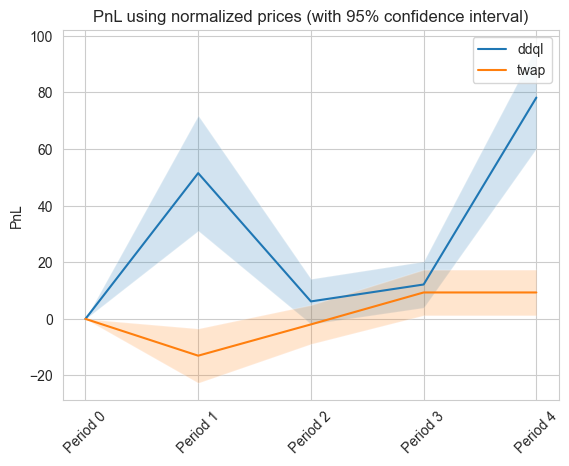

In [114]:
confidence_level = .95

plt.plot(pnl_ddql.mean(axis=0), label='ddql')
plt.fill_between(range(len(pnl_ddql.mean(axis=0))), pnl_ddql.mean(axis=0)-confidence_level*pnl_ddql.std(axis=0)/np.sqrt(len(pnl_ddql)), pnl_ddql.mean(axis=0)+confidence_level*pnl_ddql.std(axis=0)/np.sqrt(len(pnl_ddql)), alpha=.2)
plt.plot(pnl_twap.mean(axis=0), label='twap')
plt.fill_between(range(len(pnl_twap.mean(axis=0))), pnl_twap.mean(axis=0)-confidence_level*pnl_twap.std(axis=0)/np.sqrt(len(pnl_twap)), pnl_twap.mean(axis=0)+confidence_level*pnl_twap.std(axis=0)/np.sqrt(len(pnl_twap)), alpha=.2)
plt.legend()
plt.xticks(
    rotation=45, ticks=range(5), labels=[f"Period {i}" for i in range(5)]
)

plt.title(r'PnL using normalized prices (with 95% confidence interval)')
plt.ylabel('PnL')
plt.show()

Text(0.5, 0, 'PnL')

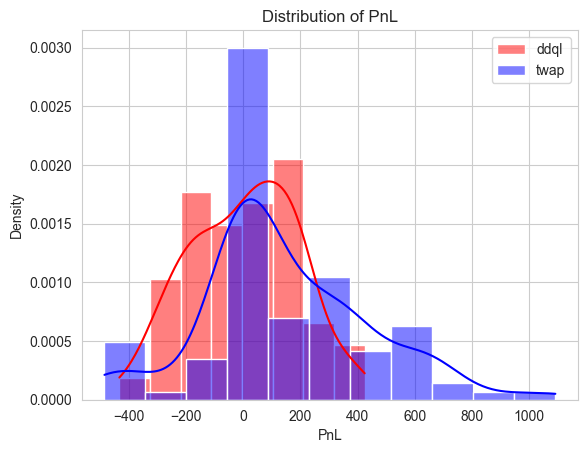

In [115]:
#distribution of rewards



sns.histplot(pnl_twap.sum(axis=1), label='ddql', kde=True, stat='density', color='red', alpha=.5)
sns.histplot(pnl_ddql.sum(axis=1), label='twap', kde=True, stat='density', color='blue', alpha=.5)
plt.legend()
plt.title('Distribution of PnL')
plt.xlabel('PnL')

In [116]:
np.mean(pnl_twap.sum(axis=1))-np.mean(pnl_ddql.sum(axis=1))

-144.30196863550725

In [6]:

# Draft Martial

import pandas as pd
import numpy as np

def fake_data(S : float = 100, r : float = 0.1, sigma : float = 0.2, start='2022-01-01 11:00:01', end='2022-01-01 13:00:00'):
    # Creation of the dataset output
    data = pd.DataFrame(pd.date_range(start=start, end=end,  freq = "s"), columns=['Date'])
    num_points, _ = np.shape(data)

    # Simulate a Black-Scholes trajectory
    dt = 1/252/6.5/3600 # scale of a second
    drift = (r - 0.5 * sigma**2) * dt
    diffusion = sigma * np.sqrt(dt) * np.random.normal(size=num_points - 1)
    log_returns = np.concatenate([[0], drift + diffusion])
    log_prices = np.cumsum(log_returns)
    prices = S * np.exp(log_prices)
    
    data["Price"] = prices
    data.set_index('Date', inplace=True)


    return data


In [7]:
for i in range(100):
    fake_data(start="2022-01-01 11:00:01", end="2022-01-01 12:00:00").to_csv(f"../data/fake_data_{i}.csv")
    fake_data(start="2022-01-01 12:00:01", end="2022-01-01 13:00:00").to_csv(f"../data/fake_data_{i+100}.csv")
    fake_data(start="2022-01-01 13:00:01", end="2022-01-01 14:00:00").to_csv(f"../data/fake_data_{i+200}.csv")